In [25]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
import matplotlib.pyplot as plt
from keras.models import load_model

# Plot training data

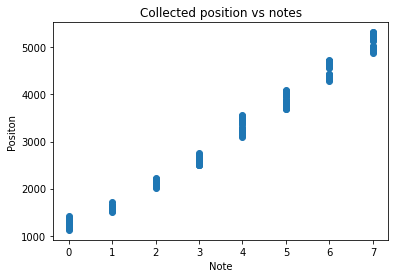

In [26]:
samples, labels = np.loadtxt('training_data.csv', delimiter=',', dtype=int)
notes = [60,62,64,65,67,69,71,72]
enc = preprocessing.LabelEncoder()
enc.fit(labels)
encoded_labels = enc.transform(labels)

plt.scatter(encoded_labels, samples)
plt.title('Collected position vs notes')
plt.xlabel('Note')
plt.ylabel('Positon')
plt.show()

# Proprocessing

In [27]:
train_samples, test_samples, train_labels, test_labels = train_test_split(samples,encoded_labels, test_size=0.1, random_state=20)
train_labels,train_samples=shuffle(train_labels,train_samples)
test_labels,test_samples=shuffle(test_labels,test_samples)


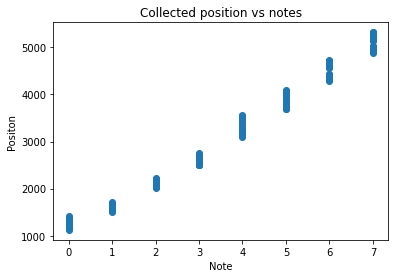

In [28]:
plt.scatter(train_labels, train_samples)
plt.title('Collected position vs notes')
plt.xlabel('Note')
plt.ylabel('Positon')
plt.show()

# Predict with NN

In [29]:
#Model
model=Sequential([Dense(units=64,input_shape=(1,),activation='relu'),
                 Dense(units=32,activation='relu'),
                 Dense (units=8,activation='softmax')])

#Training
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x=train_samples,y=train_labels,epochs=3000,validation_data=(test_samples, test_labels),verbose=1)
model.summary()

Epoch 1/3000
7/7 [==============================] - 0s 20ms/step - loss: 424.8717 - accuracy: 0.1121 - val_loss: 260.5406 - val_accuracy: 0.2500
Epoch 2/3000
7/7 [==============================] - 0s 4ms/step - loss: 318.1746 - accuracy: 0.1215 - val_loss: 191.2687 - val_accuracy: 0.2500
Epoch 3/3000
7/7 [==============================] - 0s 5ms/step - loss: 220.5431 - accuracy: 0.1168 - val_loss: 127.6102 - val_accuracy: 0.0833
Epoch 4/3000
7/7 [==============================] - 0s 5ms/step - loss: 165.4507 - accuracy: 0.1262 - val_loss: 96.8371 - val_accuracy: 0.2083
Epoch 5/3000
7/7 [==============================] - 0s 5ms/step - loss: 120.0486 - accuracy: 0.1355 - val_loss: 70.3161 - val_accuracy: 0.0417
Epoch 6/3000
7/7 [==============================] - 0s 5ms/step - loss: 88.6688 - accuracy: 0.1355 - val_loss: 51.7343 - val_accuracy: 0.2083
Epoch 7/3000
7/7 [==============================] - 0s 5ms/step - loss: 64.2675 - accuracy: 0.1589 - val_loss: 39.0189 - val_accuracy: 0.04

# Plot Results

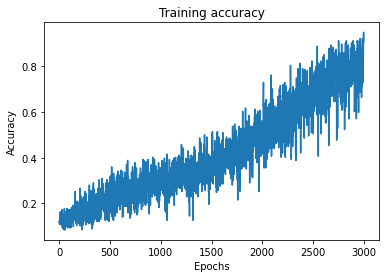

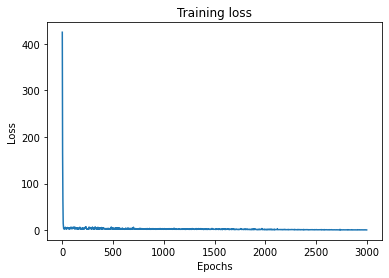

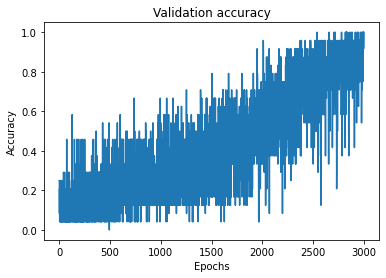

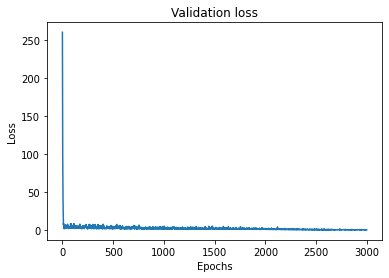

In [30]:
#Plot graph
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


plt.plot(history.history['val_loss'])
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Classify by SVM

In [31]:
from sklearn import svm
svc = svm.SVC()
svc.fit(train_samples.reshape(-1,1), train_labels)


SVC()

# Visualize Classifier

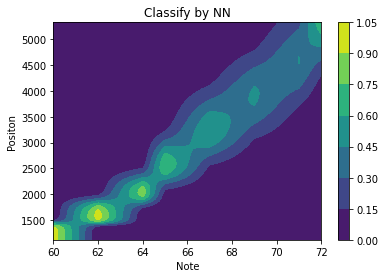

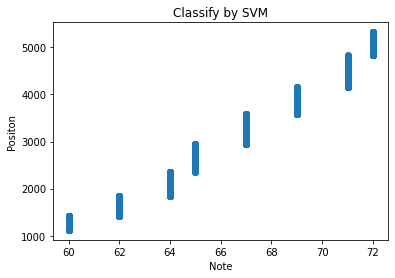

In [32]:
step=1
xs = np.arange(samples.min(), samples.max(), step)
output = model.predict(xs)
c = plt.contourf(notes, xs , output)
plt.colorbar(c)
plt.title('Classify by NN')
plt.xlabel('Note')
plt.ylabel('Positon')
plt.show()

output = svc.predict(xs.reshape(-1,1))
output = enc.inverse_transform(output)
plt.scatter(output, xs)
plt.title('Classify by SVM')
plt.xlabel('Note')
plt.ylabel('Positon')
plt.show()

# Save the training model

In [33]:
#Save model
model.save("trained_model.h5")

#Load .h5 model and predict
model = load_model('trained_model.h5')
enc.inverse_transform([np.argmax(model.predict([1100]))])[0]
# notes[np.argmax(model.predict([1100]))]


60